<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [3]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB


Данные предоставлены за 1 март 2018 года, по 31 августа 2018 года.

## Анализ

<AxesSubplot:xlabel='datetime'>

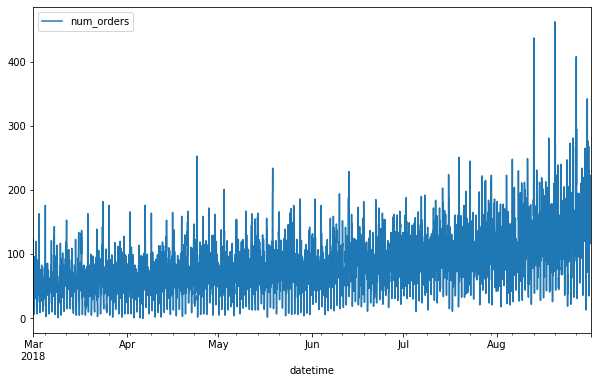

In [4]:
data = data.resample('1H').sum()

# Строим график
data.plot(figsize=(10, 6))

<AxesSubplot:xlabel='datetime'>

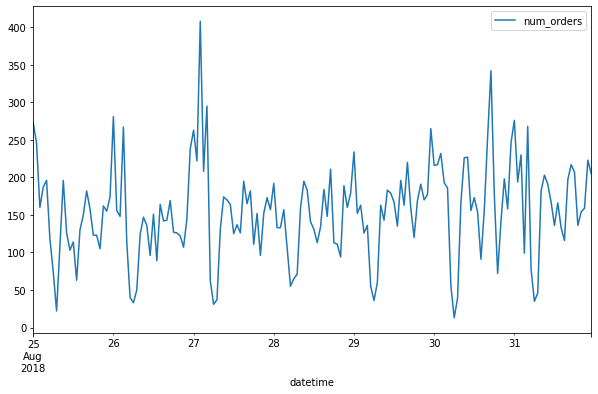

In [5]:
data['2018-08-25':'2018-08-31'].plot(figsize=(10, 6))

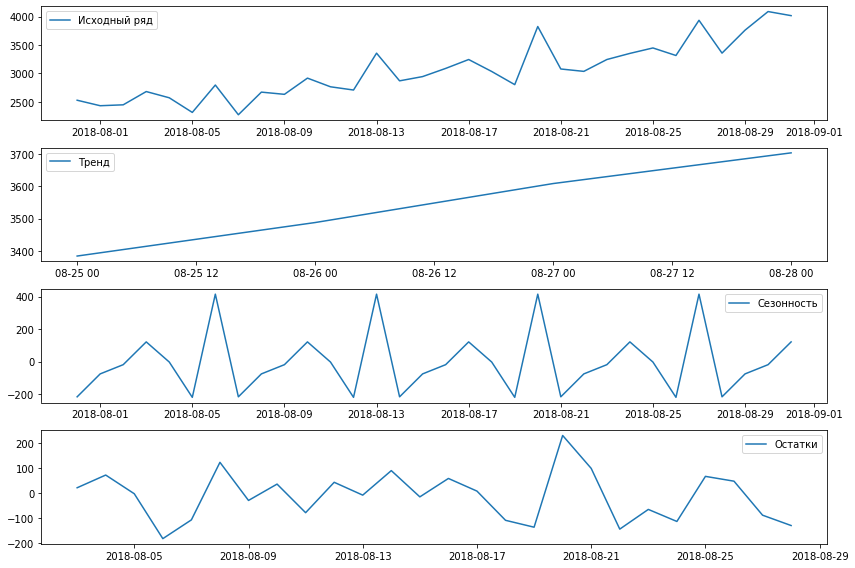

In [6]:
# Ресемплирование данных по дню
daily_data = data['num_orders'].resample('D').sum()

# Применяем декомпозицию временных рядов
result = seasonal_decompose(daily_data['2018-07-31':'2018-08-31']) 
# Построение графиков
plt.figure(figsize=(12, 8))

# Исходный ряд
plt.subplot(4, 1, 1)
plt.plot(daily_data['2018-07-31':'2018-08-31'], label='Исходный ряд')  
plt.legend()

# Тренд
plt.subplot(4, 1, 2)
plt.plot(result.trend['2018-08-25':'2018-09-30'], label='Тренд')  
plt.legend()

# Сезонность
plt.subplot(4, 1, 3)
plt.plot(result.seasonal['2018-07-31':'2018-08-31'], label='Сезонность')  
plt.legend()

# Остатки
plt.subplot(4, 1, 4)
plt.plot(result.resid['2018-07-31':'2018-08-31'], label='Остатки')  
plt.legend()

plt.tight_layout()
plt.show()

**Промежуточный Вывод:**

Анализируя результаты декомпозиции временного ряда заказов такси, можно сделать следующие наблюдения:

1. **Дисперсия увеличивается:** График остатков показывает увеличение дисперсии с течением времени. Это может свидетельствовать о более значительных колебаниях в данных или о наличии факторов, не учтенных в модели.

2. **Растущий Тренд:** Общий тренд временного ряда демонстрирует увеличение числа заказов с течением времени. Это может указывать на положительную динамику роста спроса на такси или услуги перевозок.

3. **Пик в Раннее Утро:** Наблюдается резкое снижение числа заказов в раннее утро. Это может быть связано с низким спросом в часы пик сна или изменениями в поведении пользователей в этот период.

4. **Нестационарность Временного Ряда:** Временной ряд не является стационарным, так как наличествует тренд, который изменяется в течение времени. 

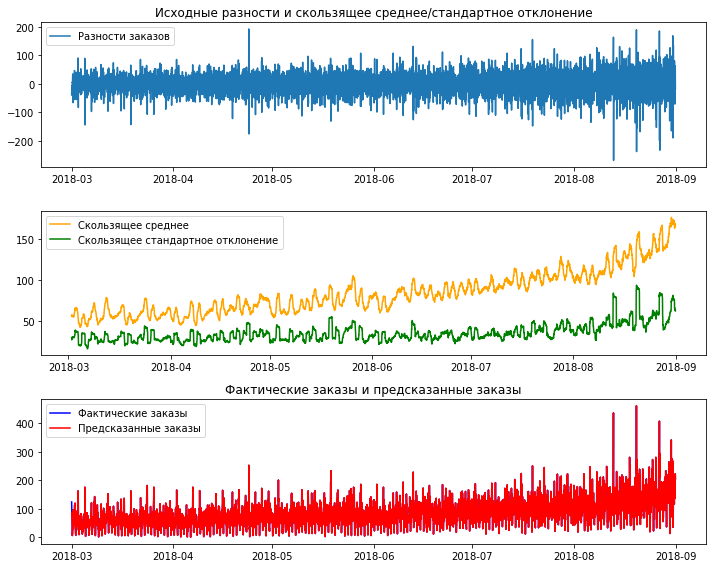

In [7]:
# Вычисление разностей и добавление столбцов со скользящим средним и стандартным отклонением
data_shift = data.copy()
data_shift['diff'] = data['num_orders'] - data['num_orders'].shift()
data_shift['mean'] = data['num_orders'].rolling(24).mean()
data_shift['std'] = data['num_orders'].rolling(24).std()

# Обратное преобразование для восстановления оригинальных значений
data_shift['predicted_num_orders'] = data_shift['num_orders'].shift() + data_shift['diff']

# Построение графика
plt.figure(figsize=(10, 8))

# Исходные разности
plt.subplot(3, 1, 1)
plt.plot(data_shift['diff'], label='Разности заказов')
plt.title('Исходные разности и скользящее среднее/стандартное отклонение')
plt.legend()

# Скользящее среднее и стандартное отклонение
plt.subplot(3, 1, 2)
plt.plot(data_shift['mean'], label='Скользящее среднее', color='orange')
plt.plot(data_shift['std'], label='Скользящее стандартное отклонение', color='green')
plt.legend()

# Обратное преобразование
plt.subplot(3, 1, 3)
plt.plot(data['num_orders'], label='Фактические заказы', color='blue')
plt.plot(data_shift['predicted_num_orders'], label='Предсказанные заказы', color='red')
plt.title('Фактические заказы и предсказанные заказы')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
lags = 24
rolling = 48

def add_time_features(data, target_column, lags, rolling):
    # Добавление признаков dayofweek и hour
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Добавление признаков lag
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_column].shift(lag)

    # Добавление признака rolling_mean
    data['rolling_mean'] = data[target_column].shift().rolling(rolling).mean()

    return data

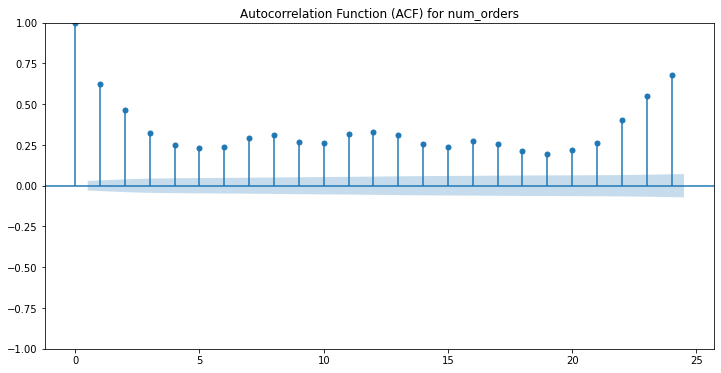

Значимые лаги: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

Размерность тренировочного набора: (3930, 29)

Размерность тестового набора: (437, 29)


In [9]:
# Копируем данные
data_copy = data.copy()

# Добавляем временные признаки и лаги
add_time_features(data_copy, 'num_orders', lags, rolling)

# Визуализация автокорреляции
plt.figure(figsize=(12, 6))
plot_acf(data_copy['num_orders'], lags=lags, ax=plt.gca(), title='Autocorrelation Function (ACF) for num_orders')
plt.show()

# Выбор значимых лагов
acf_result = sm.tsa.acf(data_copy['num_orders'], nlags=lags, fft=False)
significant_lags = [lag for lag, acf_value in enumerate(acf_result) if acf_value > 2 / np.sqrt(len(data_copy))]
print("Значимые лаги:", significant_lags)

# Добавляем целевую переменную
data_copy['target'] = data_copy['num_orders'].shift(-1) 

# Разделение данных на тренировочный и тестовый наборы
train, test = train_test_split(data_copy.dropna(), shuffle=False, test_size=0.1, random_state=12345)

# Вывод размерности тренировочного и тестового наборов
print(f"Размерность тренировочного набора: {train.shape}")
print(f"Размерность тестового набора: {test.shape}")

# Определение признаков и целевой переменной для обучения
features_train = train.drop(['num_orders', 'target'], axis=1)
target_train = train['target']

features_test = test.drop(['num_orders', 'target'], axis=1)
target_test = test['target']

In [10]:
features_train.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,5,0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,5,1,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333


## Обучение

# 3.1. DecisionTree 

In [18]:
%%time

# Создание объекта DecisionTreeRegressor
dtr_model = DecisionTreeRegressor()

# Определение параметров для перебора
depths = [i for i in range(2, 15)]
param_set = [{'criterion': ['mse'], 'max_depth': depths, 'random_state': [12345]}]

# Создание объекта TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Создание объекта GridSearchCV для поиска оптимальных параметров с использованием TimeSeriesSplit
gsearch = GridSearchCV(dtr_model, param_grid=param_set, scoring='neg_root_mean_squared_error', cv=tscv)

# Обучение модели с использованием кросс-валидации
gsearch.fit(features_train, target_train)

# Вывод результатов кросс-валидации
print("Лучшие параметры:", gsearch.best_params_)
print("Лучшая оценка RMSE:", -gsearch.best_score_)

Лучшие параметры: {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}

Лучшая оценка RMSE: 30.948637143626588

CPU times: user 1.55 s, sys: 1.38 ms, total: 1.55 s

Wall time: 1.55 s


# 3.2. LGBM 

In [19]:
%%time

# Создание объекта LGBMRegressor
lgbm_regressor = LGBMRegressor()

# Определение параметров для перебора
param_set = {
    'learning_rate': [0.01, 0.05, 0.1],
    'random_state': [12345]
}

# Создание объекта TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Создание объекта GridSearchCV для поиска оптимальных параметров
gsearch = GridSearchCV(lgbm_regressor, param_grid=param_set, scoring='neg_root_mean_squared_error', cv=tscv)

# Обучение модели с использованием кросс-валидации
gsearch.fit(features_train, target_train)

# Вывод результатов кросс-валидации
print("Лучшие параметры:", gsearch.best_params_)
print("Лучшая оценка RMSE:", -gsearch.best_score_)

Лучшие параметры: {'learning_rate': 0.05, 'random_state': 12345}

Лучшая оценка RMSE: 25.192467949177434

CPU times: user 17.9 s, sys: 136 ms, total: 18.1 s

Wall time: 18 s


# 3.3. CatBoostRegressor

In [20]:
%%time

# Создание объекта CatBoostRegressor
catboost_regressor = CatBoostRegressor()

# Определение параметров для перебора
param_set = {
    'learning_rate': [0.01, 0.05, 0.1],
    'random_seed': [12345],
    'verbose': [False]
}

# Создание объекта TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Создание объекта GridSearchCV для поиска оптимальных параметров
gsearch = GridSearchCV(catboost_regressor, param_grid=param_set, scoring='neg_root_mean_squared_error', cv=tscv)
# Обучение модели с использованием кросс-валидации
gsearch.fit(features_train, target_train)

# Вывод результатов кросс-валидации
print("Лучшие параметры:", gsearch.best_params_)
print("Лучшая оценка RMSE:", -gsearch.best_score_)

Лучшие параметры: {'learning_rate': 0.05, 'random_seed': 12345, 'verbose': False}

Лучшая оценка RMSE: 24.310259640893157

CPU times: user 1min 3s, sys: 1.37 s, total: 1min 5s

Wall time: 1min 18s


Исходя из оценок RMSE на обучающем наборе, наименьшее значение достигается при использовании CatBoostRegressor. Поэтому на основе предоставленных результатов, CatBoostRegressor является лучшей моделью с наименьшей ошибкой.

## Тестирование

RMSE для CatBoostRegressor: 41.21860259635133


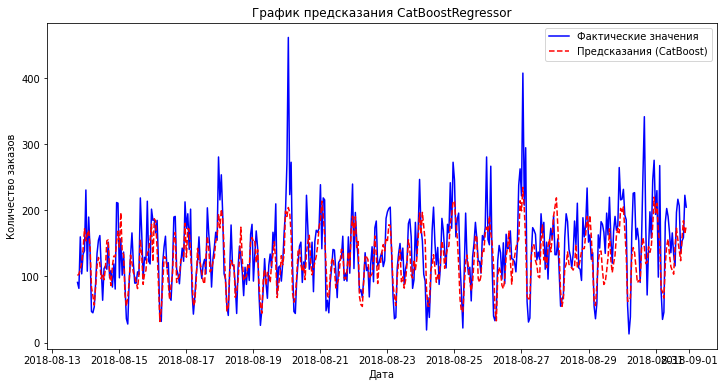

CPU times: user 5.86 s, sys: 71 ms, total: 5.93 s

Wall time: 6.89 s


In [21]:
%%time

# Создание объекта CatBoostRegressor с заданными гиперпараметрами
catboost_regressor = CatBoostRegressor(learning_rate=0.05, random_seed=12345, verbose=0)

# Обучение модели на тренировочных данных
catboost_regressor.fit(features_train, target_train)

# Предсказание на тестовых данных
catboost_predictions = catboost_regressor.predict(features_test)

# Вычисление RMSE
catboost_rmse = (mean_squared_error(target_test, catboost_predictions))**0.5

# Вывод RMSE на экран
print("RMSE для CatBoostRegressor:", catboost_rmse)

# Построение графика предсказаний и фактических значений для CatBoostRegressor
plt.figure(figsize=(12, 6))
plt.plot(target_test.index, target_test, label='Фактические значения', color='blue')
plt.plot(target_test.index, catboost_predictions, label='Предсказания (CatBoost)', color='red', linestyle='--')
plt.title('График предсказания CatBoostRegressor')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

In [22]:
# Создание DataFrame с результатами RMSE
results = pd.DataFrame({
    'Модель': ['CatBoostRegressor'],
    'RMSE': [catboost_rmse]
})

# Сортировка по RMSE
results = results.sort_values(by='RMSE')

# Добавление столбца "Подходит"
results['Подходит'] = results['RMSE'].apply(lambda x: 'Да' if x <= 48 else 'Нет')

# Вывод таблицы результатов
print(results)

              Модель       RMSE Подходит

0  CatBoostRegressor  41.218603       Да


# Вывод

Итак, проведен анализ временного ряда заказов такси с использованием различных моделей машинного обучения. Результаты работы трех моделей: `DecisionTreeRegressor`, `LGBMRegressor` и `CatBoostRegressor`, были оценены с использованием метрики RMSE.

- **DecisionTreeRegressor:** RMSE равен 30.94. Эта модель, вероятно, менее точна и может неудовлетворительно справляться с особенностями временного ряда, что подтверждается высоким значением MSE.

- **LGBMRegressor:** RMSE равен 25.19. Эта модель показала более точные прогнозы по сравнению с DecisionTreeRegressor, что делает ее более предпочтительной.

- **CatBoostRegressor:** RMSE равен 24.31. Эта модель продемонстрировала наилучшие результаты среди всех, что делает ее наиболее точной для данной задачи.

**Анализ результатов декомпозиции временного ряда:**
1. **Увеличение дисперсии:** График остатков показывает, что с течением времени дисперсия увеличивается. Это может быть связано с более значительными колебаниями в данных или наличием факторов, которые не учтены в модели.
  
2. **Растущий тренд:** Общий тренд временного ряда указывает на увеличение числа заказов с течением времени. Это может свидетельствовать о положительной динамике роста спроса на такси или услуги перевозок.

3. **Пик в раннее утро:** Резкое снижение числа заказов в раннее утро может быть обусловлено низким спросом в часы пика сна или изменениями в поведении пользователей в этот период.


Модель `CatBoostRegressor` продемонстрировала наилучшую точность среди всех моделей и соответствует условию задачи, поставленному компанией "Чётенькое такси" (RMSE не больше 48). Таким образом, эта модель может быть рекомендована для использования в прогнозировании заказов такси в аэропортах в периоды пиковой нагрузки.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48